In [1]:
import getpass
import nibabel as nib
from pathlib import Path
import os
import math
import pandas as pd
from tqdm import tqdm
import numpy as np
import random
import shutil

In [2]:
user = getpass.getuser()

src = "/home/ORUNET/" + user + "/2303_Chalmers/Data/BWT/"
nifti_paths = list(Path(src).glob('Nifti/**/*.nii'))
mask_r_paths = list(Path(src).glob('**/mask_R.nii.gz'))
mask_l_paths = list(Path(src).glob('**/mask_L.nii.gz'))

In [3]:
def save_nib_file(path, nft, nft_affine):
    nft_2_save = nib.Nifti1Image(nft, nft_affine)
    os.makedirs(os.path.dirname(path), exist_ok=True)
    nib.save(nft_2_save, path)


def calibrate_color_values(nft_imgs, low_cv = -1250, high_cv = 250):

    calibrated_values = nft_imgs.copy()
    for i, im in enumerate(calibrated_values):
        if any(any(c > high_cv or c < low_cv for c in r) for r in im):
            calibrated_values[i] = [[max(min(c, high_cv), low_cv) for c in r] for r in im]

    return ((calibrated_values - low_cv) / (high_cv-low_cv)) * 255

def get_z_start_stop(mask):
    start_z = 0

    for z in range(mask.shape[2]):
        if mask[:,:,z].any():
            start_z = z
            break

    stop_z = mask.shape[2]

    for z in reversed(range(mask.shape[2])):
        if mask[:,:,z].any():
            stop_z = z
            break

    return start_z, stop_z


def get_x_start_stop(mask):
    start_x = 0

    for x in range(mask.shape[0]):
        if mask[x,:,:].any():
            start_x = x
            break

    stop_x = mask.shape[0]

    for x in reversed(range(mask.shape[0])):
        if mask[x,:,:].any():
            stop_x = x
            break

    return start_x, stop_x

def get_y_start_stop(mask):
    start_y = 0

    for y in range(mask.shape[1]):
        if mask[:,y,:].any():
            start_y = y
            break

    stop_y = mask.shape[1]

    for y in reversed(range(mask.shape[1])):
        if mask[:,y,:].any():
            stop_y = y
            break

    return start_y, stop_y

def adjust_size_xy(nft_data, start_x, stop_x, start_y, stop_y, size=(240, 320)):

    w_diff = size[0] - (stop_x - start_x)

    start_x -= math.ceil(w_diff / 2)
    stop_x += math.floor(w_diff / 2)

    if start_x < 0:
        stop_x -= start_x
        start_x = 0
    elif stop_x > nft_data.shape[0]:
        start_x -= stop_x - nft_data.shape[0]
        stop_x = nft_data.shape[0]

    h_diff = size[1] - (stop_y - start_y)

    start_y -= math.ceil(h_diff / 2)
    stop_y += math.floor(h_diff / 2)

    if start_y < 0:
        stop_y -= start_y
        start_y = 0
    elif stop_y > nft_data.shape[1]:
        start_y -= stop_y - nft_data.shape[1]
        stop_y = nft_data.shape[1]

    return start_x, stop_x, start_y, stop_y

def save_to_df(file_name, dst_path, start_x, stop_x, start_y, stop_y, start_z, stop_z):
        
    df = pd.DataFrame({'name': [file_name],
                       'path': [dst_path],
                       'x': [[start_x, stop_x]],
                       'y': [[start_y, stop_y]],
                       'z': [[start_z, stop_z]]})
    
    dst = str(Path(dst_path).parent) + "/df.csv"

    df.to_csv(dst, mode='a',
                header=not os.path.exists(dst))


def generate_chunks(nft, mask_l, mask_r, dst_path, chunk_size=17, spacing=4):

    masks = [mask_l, mask_r]

    nft_data = nft.get_fdata()

    file_name_list = ["L", "R"]

    for i, mask in enumerate(masks):
        
        start_z, stop_z = get_z_start_stop(mask)

        for z in range(start_z + (chunk_size * spacing) * 2, stop_z - chunk_size*spacing, chunk_size * spacing):

            file_name = f"/{file_name_list[i]}_{z}_{z+chunk_size}.nii"

            start_x, stop_x = get_x_start_stop(mask[:,:, z : z + chunk_size])
            start_y, stop_y = get_y_start_stop(mask[:,:, z : z + chunk_size])

            if stop_x - start_x > nft_data.shape[0]//2:
                save_to_df(file_name, dst_path, start_x, stop_x, start_y, stop_y, z, z + chunk_size)

            start_x, stop_x, start_y, stop_y = adjust_size_xy(nft_data, start_x, stop_x, start_y, stop_y)

            chunk = calibrate_color_values(nft_data[start_x:stop_x, start_y:stop_y, z : z + chunk_size])

            save_nib_file(dst_path + file_name, chunk, nft.affine)    

In [4]:
def main():

    for nifti_path, mask_r_path, mask_l_path in tqdm(zip(nifti_paths, mask_r_paths, mask_l_paths), total=len(nifti_paths)):

        nft = nib.load(nifti_path)

        mask_r = nib.load(mask_r_path).get_fdata()
        mask_l = nib.load(mask_l_path).get_fdata()

        path = src + 'Preprocessed/' + nifti_path.stem
        
        generate_chunks(nft, mask_l, mask_r, path)

main()

100%|██████████| 57/57 [20:16<00:00, 21.34s/it]


320


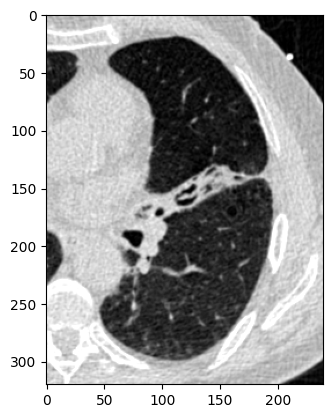

In [60]:
import matplotlib.pyplot as plt
nisan = nib.load(src + 'Preprocessed/1021_bwt/L_255_272.nii').get_fdata()
plt.imshow(np.rot90(nisan[:,:,4]), cmap='gray')
print(nisan.shape[1])

In [24]:
prep_paths = list(Path(src + 'Preprocessed/').glob('**/*.nii'))  # whereever you want to get files from
dst_dir = src +  'PreprocessedSubset' # destination folder

for og_path in tqdm(random.sample(prep_paths, 50)):
    new_name = str(og_path.relative_to(src + 'Preprocessed/')).replace("/", "_")
    output_path = os.path.join(dst_dir, new_name)
    
    nft = nib.load(og_path)
    save_nib_file(output_path, nft.get_fdata(), nft.affine)    

100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


In [4]:
df = pd.read_csv("/home/ORUNET/herbe231/2303_Chalmers/Mailbox/Till_Hanna_o_Herman/1680240979.csv")
df2 = pd.read_csv("/home/ORUNET/herbe231/2303_Chalmers/Mailbox/Till_Hanna_o_Herman/1680184624.csv")

In [5]:
list_a = [sc[-22:].replace("/", "_") for sc in list(df["src"])]
list_b = [sc[-22:] for sc in list(df2["src"])]
#print(list_a)
#print(list_b)
inconsistencies=[]

overlaps = set(list_a).intersection(set(list_b))

for path in overlaps:
    df_index = list_a.index(path)
    df2_index = list_b.index(path)

    if df.iloc[df_index]["rating"] != df2.iloc[df2_index]["rating"]:
        print(path,'      ',df.iloc[df_index]["rating"],'      ',df2.iloc[df2_index]["rating"],'      ', df.iloc[df_index]["undone"],'      ',df2.iloc[df2_index]["undone"])
        inconsistencies.append(path)

#values = set(list(df["src"])).intersection(set(list(df2["src"])))

#print(values)


1061_bwt_R_331_348.nii        0        2        False        False
1065_bwt_L_243_260.nii        0        1        False        False
1009_bwt_L_267_284.nii        0        1        False        False
1059_bwt_R_383_400.nii        0        1        False        False
1047_bwt_L_267_284.nii        0        2        False        False
1021_bwt_L_255_272.nii        0        2        False        False
1049_bwt_L_191_208.nii        0        1        False        False
1005_bwt_R_167_184.nii        0        1        False        False
1069_bwt_R_203_220.nii        1        2        False        False
1069_bwt_R_271_288.nii        0        1        False        False
1020_bwt_R_382_399.nii        0        1        False        False
1051_bwt_L_323_340.nii        1        0        False        False
1077_bwt_R_406_423.nii        0        1        False        False
1015_bwt_R_439_456.nii        0        1        False        False
1041_bwt_L_351_368.nii        0        1        False        F

In [10]:
dst_dir = src + 'NoneSubset' # destination folder

file_count = 0

dst_names = ['NoneSubset', 'MildSubset', 'ModerateSubset']
inconsistency_counter = 0
for i in range(3):
    dst_dir = src + dst_names[i]
    for og_path in tqdm(list(df[df['rating'] == i]["src"]) + list(df2[df2['rating'] == i]["src"])):
        if 'MVdrive' in og_path:
            og_path = og_path.replace('../../../../MVdrive/CTCOPD/Data_Analysis/Temp_Access', '/home/ORUNET/herbe231')
            new_name = str(Path(og_path).relative_to(src + 'PreprocessedSubset'))
        else: 
            og_path = og_path.replace('../../../Data', '/home/ORUNET/herbe231/2303_Chalmers/Data/BWT')
            new_name = str(Path(og_path).relative_to(src + 'Preprocessed')).replace("/", "_")
        if os.path.isfile(og_path):
            if new_name not in inconsistencies:
                output_path = os.path.join(dst_dir, new_name)
                
                nft = nib.load(og_path)
                save_nib_file(output_path, nft.get_fdata(), nft.affine)
            else:
                inconsistency_counter +=1
                print(inconsistency_counter)

 10%|█         | 43/414 [00:22<02:53,  2.14it/s]

1


 15%|█▍        | 62/414 [00:32<02:21,  2.49it/s]

2


 31%|███▏      | 130/414 [01:10<01:19,  3.58it/s]

3


 33%|███▎      | 138/414 [01:16<03:25,  1.34it/s]

4


 42%|████▏     | 173/414 [01:37<02:02,  1.96it/s]

5
6


 45%|████▌     | 187/414 [01:45<02:45,  1.37it/s]

7


 52%|█████▏    | 214/414 [02:00<02:01,  1.64it/s]

8


 56%|█████▌    | 232/414 [02:08<00:54,  3.34it/s]

9


 60%|██████    | 249/414 [02:19<01:36,  1.71it/s]

10


 63%|██████▎   | 260/414 [02:22<00:52,  2.94it/s]

11


 68%|██████▊   | 283/414 [02:35<01:03,  2.05it/s]

12


 70%|██████▉   | 288/414 [02:38<01:07,  1.87it/s]

13


 74%|███████▍  | 308/414 [02:50<01:09,  1.53it/s]

14


 75%|███████▌  | 311/414 [02:52<01:02,  1.65it/s]

15


 76%|███████▌  | 314/414 [02:52<00:43,  2.32it/s]

16


 77%|███████▋  | 320/414 [02:56<01:00,  1.55it/s]

17


 85%|████████▌ | 353/414 [03:21<00:47,  1.28it/s]

18


 94%|█████████▎| 388/414 [03:48<00:19,  1.33it/s]

19


  1%|          | 1/113 [00:00<01:34,  1.18it/s]

20


 12%|█▏        | 14/113 [00:09<01:12,  1.36it/s]

21


 27%|██▋       | 30/113 [00:20<01:01,  1.36it/s]

22


 31%|███       | 35/113 [00:23<00:52,  1.48it/s]

23


 49%|████▊     | 55/113 [00:38<00:45,  1.28it/s]

24


 64%|██████▎   | 72/113 [00:49<00:26,  1.57it/s]

25
26


 66%|██████▋   | 75/113 [00:49<00:16,  2.30it/s]

27


 72%|███████▏  | 81/113 [00:50<00:07,  4.50it/s]

28
29
30
31


 73%|███████▎  | 83/113 [00:51<00:07,  3.85it/s]

32


 75%|███████▌  | 85/113 [00:52<00:08,  3.46it/s]

33


 81%|████████▏ | 92/113 [00:57<00:14,  1.48it/s]

34


 90%|█████████ | 102/113 [01:03<00:04,  2.28it/s]

35
36


 95%|█████████▍| 107/113 [01:06<00:04,  1.41it/s]

37


 46%|████▌     | 11/24 [00:08<00:10,  1.29it/s]

38
39
40
41


 75%|███████▌  | 18/24 [00:10<00:02,  2.07it/s]

42
43
44


100%|██████████| 24/24 [00:13<00:00,  1.81it/s]


In [76]:
dst_dir = src + 'InconsistentSubset' # destination folder
nii_paths = []
for i in range(3):
    nii_paths += list(Path(src+dst_names[i]).glob('*.nii'))
nii_paths = [nii for nii in nii_paths if str(nii)[-22:] in inconsistencies]

22

In [8]:
dst_dir = src + 'InconsistentSubset' # destination folder
dst_names = ['NoneSubset', 'MildSubset', 'ModerateSubset']
nii_paths = []
for i in range(3):
    nii_paths += list(Path(src+dst_names[i]).glob('*.nii'))
nii_paths = [nii for nii in nii_paths if str(nii)[-22:] in inconsistencies]

for og_path in tqdm(nii_paths):
    new_name = str(og_path)[-22:]
    output_path = os.path.join(dst_dir, new_name)
    nft = nib.load(og_path)
    save_nib_file(output_path, nft.get_fdata(), nft.affine)   

100%|██████████| 44/44 [00:35<00:00,  1.26it/s]
